<div class="alert alert-block alert-info">
    <h1>Laboratorio III - 2024</h1>
    <h3>TP Final </h3>    
   <h5>Autores:</h5>
    <ul class="list-group">
        <li class="list-group-item"> Patricia Nuñez </li>
        <li class="list-group-item">Aureliano Chavarria</li>
        <li class="list-group-item">Gaston Larregui</li>
    </ul>
    <h5>Asignatura:</h5>    
    <ul class="list-group">
          <li class="list-group-item">Asignatura: Laboratorio III</li>
          <li class="list-group-item">Tema:  Trabajo Final</li>
          <li class="list-group-item">Profesor: Gustavo Denicolay</li>
     </ul>
</div>


# Cargar librerias

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from sklearn.metrics import mean_squared_error
import math
from statistics import mean
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

## Grenerales

In [2]:
import pandas as pd
#Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib')
pd.options.mode.chained_assignment = None

# En produccion eliminar, se incluye por informacion
print(f'Pandas Version: {pd.__version__}')

Pandas Version: 2.0.3


In [3]:
import matplotlib
print(f'Matplotlib version: {matplotlib.__version__}')

Matplotlib version: 3.7.1


In [4]:
import numpy as np

np.set_printoptions(suppress=True)

# En produccion eliminar, se incluye por informacion
print(f'Numpy version: {np.__version__}')

Numpy version: 1.25.2


In [5]:
# En produccion eliminar, se incluye por informacion
import matplotlib
print(f'Matplotlib version: {matplotlib.__version__}')

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)

Matplotlib version: 3.7.1


In [6]:
import seaborn as sns

In [7]:
import warnings
warnings.filterwarnings("ignore")

# Carga de Datos

In [ ]:
#sell_in_path ='/home/familialarregui/buckets/b1/datasets/sell-in.txt'
#tb_productos_path ='/home/familialarregui/buckets/b1/datasets/tb_productos.txt'
#tb_stocks_path ='/home/familialarregui/buckets/b1/datasets/tb_stocks.txt'
#prod_predecir_path ='/home/familialarregui/buckets/b1/datasets/productos_a_predecir.txt'


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
sell_in_path ='/content/drive/My Drive/Maestria Ciencia de Datos/Segundo año/Segundo Cuatrimestre/LAB_III/data/sell-in.txt'
tb_productos_path ='/content/drive/My Drive/Maestria Ciencia de Datos/Segundo año/Segundo Cuatrimestre/LAB_III/data/tb_productos.txt'
tb_stocks_path ='/content/drive/My Drive/Maestria Ciencia de Datos/Segundo año/Segundo Cuatrimestre/LAB_III/data/tb_stocks.txt'
prod_predecir_path ='/content/drive/My Drive/Maestria Ciencia de Datos/Segundo año/Segundo Cuatrimestre/LAB_III/data/productos_a_predecir.txt'
tb_prod_path ='/content/drive/My Drive/Maestria Ciencia de Datos/Segundo año/Segundo Cuatrimestre/LAB_III/data/prod_predecir_descrip.csv'


In [11]:
#data = pd.read_csv(file_path)
#sell_in = pd.read_csv(sell_in_path, delimiter='\t')
df = pd.read_csv(sell_in_path, delimiter='\t')
df_productos = pd.read_csv(tb_productos_path, delimiter='\t')
df_stocks = pd.read_csv(tb_stocks_path, delimiter='\t')
df_predecir = pd.read_csv(prod_predecir_path, delimiter='\t')

# Procesamiento inicial del dataset


## Procesamiento inicial

In [12]:
df.head(3)

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.053,0.053
1,201701,10032,20524,0,1,0.136,0.136
2,201701,10217,20524,0,1,0.030,0.030


In [13]:
# Selección de los productos a predecir tomados de df_predecir

df_prod = df[['periodo','customer_id','product_id','plan_precios_cuidados','cust_request_qty','cust_request_tn','tn']].merge(df_predecir[['product_id']], on='product_id')

df_prod.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.053,0.053
1,201701,10032,20524,0,1,0.136,0.136
2,201701,10217,20524,0,1,0.030,0.030
3,201701,10125,20524,0,1,0.023,0.023
4,201701,10012,20524,0,11,1.545,1.545


In [14]:
unique_counts = df_prod.nunique()
print(unique_counts)

periodo                     36
customer_id                597
product_id                 780
plan_precios_cuidados        2
cust_request_qty            84
cust_request_tn          92001
tn                       91942
dtype: int64


In [15]:
# Selección desde 201701 a 201910. Se realiza la predicción 201911 y 201912
periodo_seleccionados = [201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,
                         201801,201802,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812,
                         201901,201902,201903,201904,201905,201906,201907,201908,201909,201910]
total_prod = df_prod[df_prod['periodo'].isin(periodo_seleccionados)] # Aplicas el filtro utilizando la función isin()

In [16]:
unique_counts = total_prod.nunique()
print(unique_counts)

periodo                     34
customer_id                590
product_id                 780
plan_precios_cuidados        2
cust_request_qty            84
cust_request_tn          89339
tn                       89298
dtype: int64


## Preparación de paquetes por periodo de meses
paquete 1 --> 36 a 25 meses
paquete 2 --> 24 a 13 meses
paquete 3 --> 12 a 5 meses

In [17]:
#Agrupación de toneladas de cada producto en cada mes
#total_prod = total_prod.groupby(['periodo','product_id']).agg({'tn':'sum'}).reset_index()  # Predicción 201912
total_prod = df_prod.groupby(['periodo','product_id']).agg({'tn':'sum'}).reset_index() # Predicción 202002

In [18]:
# Ahora realizamos un pivot del df "producto" para luego análizar cada producto en una serie de tiempo

# Pasamos 'product_id' a string, esto se hace para luego poder tomar la columna como string para graficar
total_prod['product_id'] = total_prod['product_id'].astype(str)
# Pivotar el DataFrame cant_prod
total_prod = total_prod.pivot(index='periodo', columns='product_id', values='tn').reset_index()
# Renombrar las columnas para que sean más legibles
total_prod.columns.name = None
#df_producto.head()

In [19]:
# Reemplazar los valores NaN por cero
total_prod = total_prod.fillna(0)

In [20]:
total_prod.head()

,periodo,20001,20002,20003,20004,20005,20006,20007,20008,20009,20010,20011,20012,20013,20014,20015,20016,20017,20018,20019,20020,20021,20022,20023,20024,20025,20026,20027,20028,20029,20030,20031,20032,20033,20035,20037,20038,20039,20041,20042,20043,20044,20045,20046,20047,20049,20050,20051,20052,20053,20054,20055,20056,20057,20058,20059,20061,20062,20063,20065,20066,20067,20068,20069,20070,20071,20072,20073,20074,20075,20076,20077,20079,20080,20081,20082,20084,20085,20086,20087,20089,20090,20091,20092,20093,20094,20095,20096,20097,20099,20100,20101,20102,20103,20106,20107,20108,20109,20111,20112,20114,20116,20117,20118,20119,20120,20121,20122,20123,20124,20125,20126,20127,20129,20130,20132,20133,20134,20135,20137,20138,20139,20140,20142,20143,20144,20145,20146,20148,20150,20151,20152,20153,20155,20157,20158,20159,20160,20161,20162,20164,20166,20167,20168,20170,20174,20175,20176,20177,20179,20180,20181,20182,20183,20184,20187,20188,20189,20192,20193,20196,20197,20198,20200,20201,20202,20203,20205,20206,20207,20208,20209,20210,20211,20212,20213,20215,20216,20218,20219,20220,20222,20224,20225,20226,20227,20228,20230,20231,20232,20233,20234,20235,20236,20237,20238,20239,20240,20241,20242,20244,20246,20249,20251,20252,20253,20254,20255,20256,20257,20259,20261,20262,20263,20264,20265,20266,20267,20268,20269,20270,20271,20272,20273,20275,20276,20277,20278,20280,20281,20282,20283,20284,20285,20286,20288,20289,20290,20291,20292,20295,20296,20297,20298,20299,20300,20301,20302,20303,20304,20305,20306,20307,20309,20310,20311,20313,20314,20315,20316,20317,20319,20320,20321,20322,20323,20324,20325,20326,20327,20328,20329,20330,20332,20334,20335,20336,20337,20338,20340,20341,20342,20343,20344,20346,20348,20349,20350,20351,20352,20353,20354,20355,20356,20357,20358,20359,20361,20362,20364,20365,20366,20367,20368,20372,20375,20377,20378,20379,20380,20381,20382,20383,20384,20385,20386,20387,20388,20389,20390,20395,20396,20398,20400,20401,20402,20403,20404,20406,20407,20408,20409,20410,20411,20414,20415,20416,20417,20418,20419,20421,20422,20424,20426,20428,20429,20432,20433,20434,20438,20440,20442,20443,20447,20449,20450,20453,20456,20458,20459,20460,20463,20464,20465,20466,20469,20470,20473,20474,20476,20477,20478,20479,20480,20481,20482,20483,20484,20488,20490,20491,20495,20496,20497,20500,20502,20503,20505,20508,20509,20510,20513,20514,20517,20520,20521,20522,20523,20524,20525,20526,20527,20530,20531,20532,20536,20537,20538,20539,20540,20541,20542,20544,20547,20548,20549,20551,20552,20553,20555,20558,20559,20560,20561,20563,20565,20567,20568,20569,20570,20571,20572,20574,20575,20576,20577,20578,20579,20580,20583,20585,20586,20588,20589,20592,20593,20596,20597,20599,20600,20601,20602,20603,20604,20605,20606,20609,20611,20612,20614,20615,20617,20620,20621,20622,20623,20624,20627,20628,20629,20632,20633,20636,20637,20638,20639,20640,20641,20642,20644,20646,20647,20649,20651,20652,20653,20654,20655,20657,20658,20659,20660,20661,20662,20663,20664,20666,20667,20670,20672,20673,20674,20676,20677,20678,20679,20680,20681,20682,20684,20685,20686,20689,20691,20693,20694,20696,20697,20699,20700,20701,20702,20703,20705,20706,20708,20709,20711,20713,20714,20715,20719,20720,20721,20724,20729,20730,20732,20733,20735,20737,20739,20741,20742,20743,20744,20745,20746,20749,20750,20751,20754,20756,20757,20758,20759,20761,20762,20765,20768,20771,20772,20773,20774,20775,20777,20781,20783,20785,20786,20788,20789,20793,20795,20800,20801,20802,20803,20807,20809,20810,20811,20812,20815,20817,20818,20820,20822,20823,20824,20826,20827,20828,20830,20831,20832,20835,20838,20840,20843,20845,20846,20847,20849,20852,20853,20855,20859,20862,20863,20864,20865,20870,20877,20878,20879,20882,20883,20885,20886,20892,20894,20899,20901,20902,20904,20906,20907,20908,20910,20912,20913,20914,20917,20919,20920,20922,20924,20925,20927,20928,20931,20932,20933,20936,20937,20941,20942,20945,20946,20947,20948,20949,20951,20953,20956,20957,20961,20962,20965,20966,20967,20968,20970,20975,20976,2

In [24]:
total_prod = total_prod.drop(columns=['periodo'])

In [26]:
cant_meses = total_prod.nunique().reset_index()
cant_meses.columns = ['product_id', 'meses']
cant_meses = cant_meses.sort_values(by='meses', ascending=False)


In [27]:
cant_meses.head()

,product_id,meses
0,20001,36
353,20449,36
367,20474,36
366,20473,36
365,20470,36


In [48]:
# Paquete 1: product_id con meses entre 36 y 24
paquete_1 = cant_meses.query('24 < meses <= 36').reset_index()
paquete_1['product_id'] = paquete_1['product_id'].astype(int)

# Paquete 2: product_id con meses entre 24 y 12
paquete_2 = cant_meses.query('12 < meses <= 24').reset_index()
paquete_2['product_id'] = paquete_2['product_id'].astype(int)

# Paquete 3: product_id con meses entre 12 y 5
paquete_3 = cant_meses.query('5 <= meses <= 12').reset_index()
paquete_3['product_id'] = paquete_3['product_id'].astype(int)

In [45]:
frecuencia_meses = cant_meses['meses'].value_counts()
#frecuencia_meses = frecuencia_meses.sort_values(by='meses', ascending=False)
#print(frecuencia_meses)

## Preparación data final

In [46]:
df_final_1 = df_prod[['periodo','customer_id','product_id','plan_precios_cuidados','cust_request_qty','cust_request_tn','tn']].merge(paquete_1[['product_id']], on='product_id')
df_final_2 = df_prod[['periodo','customer_id','product_id','plan_precios_cuidados','cust_request_qty','cust_request_tn','tn']].merge(paquete_2[['product_id']], on='product_id')
df_final_3 = df_prod[['periodo','customer_id','product_id','plan_precios_cuidados','cust_request_qty','cust_request_tn','tn']].merge(paquete_3[['product_id']], on='product_id')


In [40]:
df_final_3.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201902,10182,21168,0,1,0.001,0.001
1,201902,10323,21168,0,1,0.002,0.002
2,201902,10366,21168,0,1,0.005,0.005
3,201902,10098,21168,0,2,0.013,0.013
4,201902,10227,21168,0,2,0.008,0.008


In [ ]:
# Selección desde 201701 a 201910. Se realiza la predicción 201911 y 201912
periodo_seleccionados = [201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,
                         201801,201802,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812,
                         201901,201902,201903,201904,201905,201906,201907,201908,201909,201910]
#total_prod_1 = df_final_1[df_final_1['periodo'].isin(periodo_seleccionados)] # Aplicas el filtro utilizando la función isin()
#total_prod_2 = df_final_2[df_final_2['periodo'].isin(periodo_seleccionados)] # Aplicas el filtro utilizando la función isin()
#total_prod_3 = df_final_3[df_final_3['periodo'].isin(periodo_seleccionados)] # Aplicas el filtro utilizando la función isin()

In [47]:
unique_counts = df_final_3.nunique()
print(unique_counts)

periodo                    11
customer_id               480
product_id                 49
plan_precios_cuidados       2
cust_request_qty           49
cust_request_tn          4179
tn                       4184
dtype: int64


In [ ]:
#Agrupación de toneladas de cada producto en cada mes
#total_prod_1 = total_prod_1.groupby(['periodo','product_id']).agg({'tn':'sum'}).reset_index()  # Predicción 201912
total_prod_1 = df_final_1.groupby(['periodo','product_id']).agg({'tn':'sum'}).reset_index() # Predicción 202002
total_prod_2 = df_final_2.groupby(['periodo','product_id']).agg({'tn':'sum'}).reset_index() # Predicción 202002
total_prod_3 = df_final_3.groupby(['periodo','product_id']).agg({'tn':'sum'}).reset_index() # Predicción 202002

In [ ]:
# Ahora realizamos un pivot del df "producto" para luego análizar cada producto en una serie de tiempo

#Paquete 1
# Pasamos 'product_id' a string, esto se hace para luego poder tomar la columna como string para graficar
total_prod_1['product_id'] = total_prod_1['product_id'].astype(str)
# Pivotar el DataFrame cant_prod
total_prod_1 = total_prod_1.pivot(index='periodo', columns='product_id', values='tn').reset_index()
# Renombrar las columnas para que sean más legibles
total_prod_1.columns.name = None

#Paquete 2
# Pasamos 'product_id' a string, esto se hace para luego poder tomar la columna como string para graficar
total_prod_2['product_id'] = total_prod_2['product_id'].astype(str)
# Pivotar el DataFrame cant_prod
total_prod_2 = total_prod_2.pivot(index='periodo', columns='product_id', values='tn').reset_index()
# Renombrar las columnas para que sean más legibles
total_prod_2.columns.name = None

#Paquete 3
# Pasamos 'product_id' a string, esto se hace para luego poder tomar la columna como string para graficar
total_prod_3['product_id'] = total_prod_3['product_id'].astype(str)
# Pivotar el DataFrame cant_prod
total_prod_3 = total_prod_3.pivot(index='periodo', columns='product_id', values='tn').reset_index()
# Renombrar las columnas para que sean más legibles
total_prod_3.columns.name = None

In [ ]:
# Reemplazar los valores NaN por cero
total_prod_1 = total_prod_1.fillna(0)
total_prod_2 = total_prod_2.fillna(0)
total_prod_3 = total_prod_3.fillna(0)

In [ ]:
#paquete 1 [0-568] -- [periodo - 21224] -- Ingresar [1:569] (20001 - 21224)
#paquete 2 [0-89] -- [periodo - 21263] -- Ingresar [1:89] (20085 - 21263)
#paquete 3 [0-125] -- [periodo - 21276] -- Ingresar [1:125] (20032 - 21276)
prueba = total_prod_3.columns[1:101]
print(prueba)


Index(['20032', '20127', '20174', '20210', '20213', '20236', '20257', '20261',
       '20286', '20355', '20414', '20440', '20442', '20458', '20476', '20491',
       '20510', '20521', '20525', '20526', '20531', '20537', '20548', '20575',
       '20577', '20592', '20593', '20603', '20615', '20620', '20621', '20623',
       '20633', '20649', '20659', '20662', '20673', '20674', '20681', '20686',
       '20691', '20694', '20703', '20711', '20719', '20720', '20732', '20746',
       '20754', '20757', '20762', '20772', '20774', '20785', '20795', '20815',
       '20822', '20827', '20845', '20859', '20886', '20899', '20904', '20907',
       '20910', '20912', '20920', '20924', '20927', '20928', '20932', '20933',
       '20942', '20946', '20953', '20962', '20966', '20968', '20975', '20987',
       '20995', '21006', '21007', '21033', '21035', '21039', '21042', '21044',
       '21058', '21064', '21073', '21074', '21079', '21086', '21087', '21092',
       '21097', '21099', '21109', '21110'],
      dt

## Modelo LSTM - Todos los productos

In [ ]:
# Fijar las semillas para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Función para crear el dataset con una ventana de tiempo
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

######## Paquete 1 ###################################
prediccion = pd.DataFrame(columns=['product_id', 'tn'])
for product_id in total_prod_1.columns[1:569]: # comienzo desde el primer producto
    # Usar solo la columna del producto actual
    data = total_prod_1[[product_id]].values

    # Convertir los datos a un array numpy y luego cambiar la forma a 2D
    data_reshaped = np.array(data).reshape(-1, 1)

    # Normalizar los datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_reshaped)

    # Crear el dataset con una ventana de tiempo (time_step)
    time_step = 3
    N_UNITS = 128
    BATCH = 6
    EPOCHS = 100

    X, y = create_dataset(scaled_data, time_step)

    # Dividir los datos en entrenamiento y prueba
    train_size = int(len(X) * 0.8)
    test_size = len(X) - train_size
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    y_train, y_test = y[0:train_size], y[train_size:len(y)]

    # Redimensionar datos para que sean compatibles con LSTM [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Construir el modelo LSTM
    #model = Sequential()
    #model.add(LSTM(N_UNITS,input_shape=(time_step, 1)))
    #model.add(Dense(25))#, activation='linear')) # activation = tanh / sigmoid / relu / softmax / linear
    #model.add(Dense(1,activation='linear'))

    model = Sequential()
    model.add(LSTM(N_UNITS,activation='relu',input_shape=(time_step, 1)))
    model.add(Dense(1))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Entrenar el modelo
    history = model.fit(X_train, y_train, batch_size=BATCH, epochs=EPOCHS, verbose=0)

    # Hacer predicciones mes 1 y 2
    predictions = []
    last_data = scaled_data[-time_step:]  # Empezar con los últimos 'time_step' meses
    for _ in range(2):
        # Hacer la predicción para el siguiente mes
        last_data_reshaped = last_data.reshape((1, time_step, 1))
        next_pred = model.predict(last_data_reshaped)

        # Invertir la normalización para obtener la predicción real
        next_pred_real = scaler.inverse_transform(next_pred)
        predictions.append(next_pred_real[0][0])

        # Actualizar 'last_data' para la próxima predicción
        last_data = np.append(last_data[1:], next_pred, axis=0)

    #print(f'Predicción para el mes +1: {predictions[0]}') # 201911-1037.068-Total de clientes--> 1397.372(20001)/ 142.577(20002) / 948.294(20003)
    #print(f'Predicción para el mes +2: {predictions[1]}') # 201912-1073.665-Total de clientes--> 1504.689(20001)/ 1087.309(20002) / 892.501(20003)

    # Guardar la predicción en el nuevo dataframe usando concat
    new_row = pd.DataFrame({'product_id': [product_id], 'tn': [predictions[1]]})
    prediccion = pd.concat([prediccion, new_row], ignore_index=True)

################## Error ##############
# Selección desde 201701 a 201910. Se realiza la predicción 201911 y 201912
periodo_19 = [201912]
total_prod_19 = df_prod[df_prod['periodo'].isin(periodo_19)] # Aplicas el filtro utilizando la función isin()
#Agrupación de toneladas de cada producto en cada mes
total_prod_19 = total_prod_19.groupby(['periodo','product_id']).agg({'tn':'sum'}).reset_index()
total_prod_19 = total_prod_19.head(11)
real_19 = total_prod_19.drop(columns=['periodo'])
dif = abs(prediccion['tn']-real_19['tn'])
suma = dif.sum()
suma_real = real_19['tn'].sum()
error = 100*(suma / suma_real)
print(error)
#######################################
# Guardar las predicciones en un archivo CSV
prediccion.to_csv('/home/familialarregui/buckets/b1/exp/pack01_ts3_NU128_B6_E100.txt', index=False)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

# Kaggle

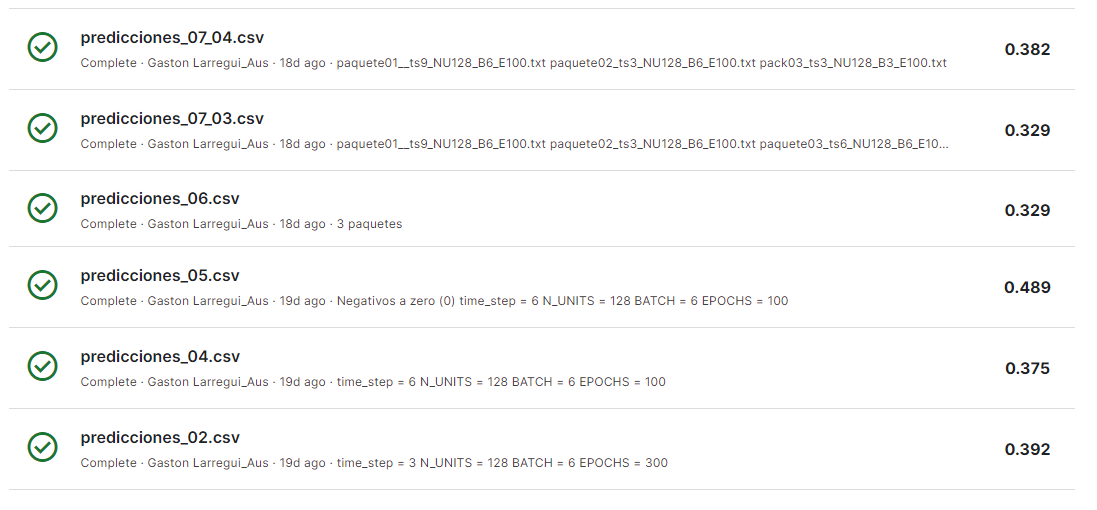